In [1]:
import pandas as pd
from sklearn import preprocessing
from scipy.interpolate import RectBivariateSpline, griddata
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm_notebook
import re
import sys

## Вспомогательные функции

## Чтение `X`-`Y`-`P`-`t`-таблиц для скважин с заданными номерами

In [2]:
def store_file_in_dict(filename='./108000/MapGrid1.txt'):
    """ Store one text-file with well-data in a dict.
    """
    with open(filename, 'r') as file:
        text = file.read()
    result = dict()
    chunks = text.split('Frac_num')
    for chunk in chunks[1:]:
        frac_num = int(chunk.splitlines()[0].split('=')[1])
        lines = chunk.splitlines()[1:]
        df = pd.read_csv(StringIO('\n'.join(lines)), delim_whitespace=True,
                         names=['X', 'Y', 'value'])
        result.update({frac_num: df})

    return result

In [3]:
def store_all_files_in_dicts(path_mask='./108000/MapGrid*.txt', sort=True):
    """ Create a list of dicts storing well-logs data for a range of files.
    """
    dicts = []
    if sort:
        paths = sorted(glob(path_mask),
                       key=lambda s: int(re.sub(r'[a-z]|[A-Z]|\.', '', s.split('/')[-1])))
    else:
        paths = glob(path_mask)
    for path in tqdm_notebook(paths):
        dicts.append(store_file_in_dict(filename=path))
    return dicts

In [4]:
ordered_paths = sorted(glob('./108000/MapGrid*.txt'), key=lambda s:
                       int(re.sub(r'[a-z]|[A-Z]|\.', '', s.split('/')[-1])))

In [5]:
ds = store_all_files_in_dicts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [6]:
def get_sample_series(dicts, frac_num=96001, splits=(None, None)):
    """ Get series of samples from an ordered list of dicts.
    """
    arrays = []
    for i, dict_ in enumerate(dicts):
        arrays.append(np.concatenate([dict_.get(frac_num).values,
                                      i * np.ones(shape=(400, 1))], axis=1))
        
    if splits[0] is None:
        total = np.concatenate(arrays, axis=0)
        result = pd.DataFrame(total, columns=['X', 'Y', 'value', 't'])
        return result
    else:
        array_train, array_test = [arrays[t] for t in splits[0]], [arrays[t] for t in splits[1]]
        array_train, array_test = (np.concatenate(array_train, axis=0),
                                   np.concatenate(array_test, axis=0))
        return (pd.DataFrame(array_train, columns=['X', 'Y', 'value', 't']),
                pd.DataFrame(array_test, columns=['X', 'Y', 'value', 't']))

In [7]:
def get_sample(text=None, filename='./108000/MapGrid1.txt', num=1):
    if text is None:
        with open(filename, 'r') as file:
            text = file.read()
    lines = text.split('Frac_num')[num].splitlines()[1:]
    result = pd.read_csv(StringIO('\n'.join(lines)), delim_whitespace=True,
                         names=['X', 'Y', 'value'])
    return result

In [8]:
def get_frac_num(text=None, filename='./108000/MapGrid1.txt', num=1):
    if text is None:
        with open(filename, 'r') as file:
            text = file.read()
    return int(text.split('Frac_num')[num].splitlines()[0].split('=')[1])

## Функции для интерполяции скважинных таблиц

In [9]:
from scipy.interpolate import Rbf, LinearNDInterpolator

In [10]:
def normalize_and_get_inverse(df):
    normalized = (df - df.min()) / (df.max() - df.min())
    inverse = lambda data: data * (df.max() - df.min()) + df.min()
    return normalized, inverse

In [11]:
def interpolate_and_compute_in_grid(sample, method='linear', grid=None):
    if grid is None:
        grid_x, grid_y, grid_t = np.mgrid[0:0.01:50j, 0:0.01:50j, 0:1.0:20j]
    else:
        grid_x, grid_y, grid_t = grid

    normalized, inverse = normalize_and_get_inverse(sample)
    points = normalized[['X', 'Y', 't']].values
    values = normalized[['value']].values.reshape(-1)
    grid_result = griddata(points, values, (grid_x, grid_y, grid_t),
                           method=method)
    return grid_result

In [197]:
def dataframe_to_grid_sequence(sample, n_points=20):
    dfs = []
    times = []
    groups = sample.groupby('t')
    for k, v in groups:
        dfs.append(v[['X', 'Y', 'value']].values.reshape((n_points, n_points, 3)))
        times.append(k)
    return dfs, times

In [198]:
def get_interpolator_and_inverse(sample, method='rbf', **kwargs):
    normalized, inverse = normalize_and_get_inverse(sample)
    points = normalized[['X', 'Y', 't']].values
    values = normalized[['value']].values.reshape(-1)

    # make the interpolator of requested type
    if method == 'rbf':
        interp = Rbf(points[:, 0], points[:, 1], points[:, 2], **kwargs)
    elif method == 'linear':
        interp = LinearNDInterpolator(points, values)
    return interp, inverse

In [199]:
from itertools import product

In [209]:
def make_grid_df(xlim=(0, 0.01), ylim=(0, 0.01), tlim=(0, 1), n_points=20):
    data = product(np.linspace(*xlim, n_points),
                   np.linspace(*xlim, n_points),
                   np.linspace(*tlim, n_points))
    data = list(data)
    return pd.DataFrame(data, columns=['X', 'Y', 't'])

## Визуальный и численный тест: отложенная по $t$ выборка на скважине с `frac_num` $96001 $

In [226]:
train_s, test_s = get_sample_series(ds, splits=(np.arange(0, 20, 2),
                                                np.arange(1, 19, 2)))

In [227]:
interp, inv = get_interpolator_and_inverse(train_s, method='linear')

In [228]:
normalized_test, inv_test = normalize_and_get_inverse(test_s)

In [229]:
griddf = make_grid_df()

In [232]:
griddf_pred = make_df_with_predictions(griddf, interp)

In [233]:
pred_grids, times = dataframe_to_grid_sequence(griddf_pred)

In [234]:
pred_grids[0].shape

(20, 20, 3)

* визуально моменты времени вне обучающей выборки выглядят качественно

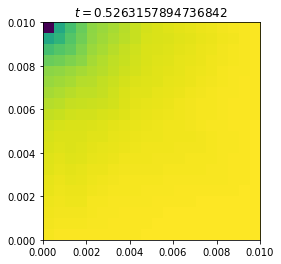

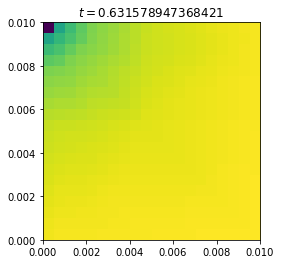

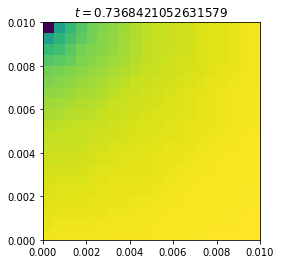

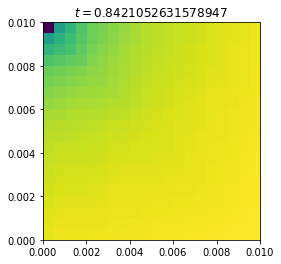

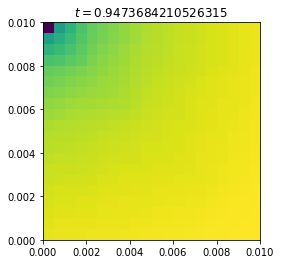

In [251]:
for i in range(10, len(pred_grids), 2):
    plt.imshow(pred_grids[i][..., -1],
               extent=(0, 0.01, 0, 0.01))
    plt.title(r'$t={}$'.format({times[i]}))
    plt.show()

In [32]:
vs = interp(normalized_test[['X', 'Y', 't']].values)

* средняя абсолютная ошибка на тестовой выборке

In [253]:
np.mean(np.abs(vs - normalized_test.value.values))

0.0008931845357092848

* средняя относительная ошибка на тестовой выборке, в % - только по ненулевым значениям

In [258]:
np.nanmean(np.abs(vs - normalized_test.value.values) / normalized_test.value.values) * 100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


0.1658227229244647

## Тест на данных от Андрея

In [220]:
import pandas as pd

In [221]:
fields = ('K', 'half_length', 'Skin', 'h', 'por', 'Q_frac', 'Frac_num')

* считываем параметры из входной выборки и тестовые параметры

In [222]:
params_sample = pd.read_excel('Parameters/parameters_sample.xls', delim_whitespace=True)

In [223]:
params_test = pd.read_excel('Parameters/parameters_test.xlsx', delim_whitespace=True)

In [224]:
params_test

,K,half_length,Skin,h,por,Q_frac,"mu, сП","Сжим, 1/Па",Угол,Unnamed: 9,Размер залежи
0,11.2,223.11,0,10.8,0.1,66.67,1,4.351130e-10,0,NaN,100км на 100км


* в параметрах из входного датасета не содержится значения `Q_frac` $66.67$

In [225]:
params_sample.Q_frac.unique()

array([-400.        , -322.22222222, -244.44444444, -166.66666667,
        -88.88888889,  -11.11111111])